# Model Project: Comparison of Results from the Principal-Agent Model with  and without Education as signaling

**Table of contents**<a id='toc0_'></a>    
- [Part 1: The Principal Agent Model with adverse selection](#toc1_)    
  - [Solving the model](#toc1_1_)    
    - [Optimal contract with baseline parameters](#toc1_1_1_)    
    - [Boundary/corner solutions](#toc1_1_2_)    
- [Part 2: Introducing Education as Signaling](#toc2_)    
  - [Presenting the model](#toc2_1_)    
  - [Solving the model](#toc2_2_)    
    - [Solving the model with baseline parameters](#toc2_2_1_)    
    - [Varying the parameters](#toc2_2_2_)    
    - [Boundary/corner solutions](#toc2_2_3_)    
    - [Varying the outside options](#toc2_2_4_)    
    - [Varying the shares of high- and low productivity workers](#toc2_2_5_)    
      - [Interactive plot: Varying the share of high productivity workers](#toc2_2_5_1_)    
- [Part 3: What if we added more types of workers to the model?](#toc3_)    
  - [The model with n types of agents](#toc3_1_)    
  - [Solving the model](#toc3_2_)    
  - [Plotting the solution](#toc3_3_)    
- [Conclusion](#toc4_)    
  - [Part 1](#toc4_1_)    
  - [Part 2](#toc4_2_)    
  - [Part 3](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
from IPython.display import display
from scipy.stats import norm

import pandas as pd 
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import PrincipalAgent

# The Principal Agent Model


## <a id='toc1_'></a>[Part 1: The Principal Agent Model with adverse selection](#toc0_)

Consider an economy that consists of a principal that wish to hire workers. There are two types of workers, respectively high and low productivity workers. The principal has full information on the shares of different worker types, and all the parameters characterizing the different worker types. However, the principal is not able to identify whether a worker is a low or high productivity worker, but each worker is aware of which type he/she is, i.e. there is asymmetric information. Therefore, if the principal seeks to hire both types of workers, he/she faces the following maximization problem:

$$
\begin{align*}
\max_{w} \pi  & = q(y_H - w)+(1-q)(y_L - w)\\
& \text{s.t.} \\
\tag{$IR_H$} w & \ge r_H \\ 
\tag{$IR_L$} w & \ge r_L
\end{align*}
$$

where $w$ is the wage rate offered in the optimal contract, $r_i$ is the outside utility and $y_i$ is the productivity. The subscript $i$ of either H or L denotes if the agent has high ($H$) or low productivity ($L$). Furthermore, we assume that the agents recieve utility corresponding to their wage.

The constraints under which we optimize the profits are called the individual rationality constraints ($IR_H$/$IR_L$). They ensure that the agents accept the offered contract. This implies that the utility of accepting the contract is higher than their outside utility.

### <a id='toc1_1_'></a>[Solving the model](#toc0_)

**Solution algorithm:**
1. Setup baseline parameters in `self.__init__()` in the class `PrincipalAgent()`

2. Formulate the profit function stated above in `self.profits_one(w)`. Here it is important to let the profit function take different forms depending on whether the IR-constraints are satisfied or not:
    * If both IR-constraints are violated: return no profits as the none of the worker types accepts the contract.
    * If only one of the IR-constraints hold: only return the profits from the workers whose IR-constraint is satisfied.
    * If both IR-constraints hold: return the profit function as stated above.
    
3. Define objectiv functions and constraints (`self.objective_one(x)`, `self.ineq_IR_H_one(x)`, `self.ineq_IR_L_one(x)`). As we will later use a numerical constrained optimizer that solves for the argument minimizing the objective function, we define the objective function as the negative of the profit function. The constraint functions corresponds to the IR constraints stated above. In all functions `x` is stated as the argument. This is the argument that we will optimize with relation to, and in this case `x` is a scalar that just reflects the wage in the optimal contract. 

4. Call an optimizer and solve the model. We call the optimizer `scipy.optimize.minimize` and use the method SLSQP. We use SLSQP as we have a constrained optimization problem, and the SLSQP-method is good at handling constraints. We specify the objective functions and constraints from step 3 in this optimizer. We also specify the bounds for the wage as all non-negative values.

5. Step 4 found the inner solution to the problem, i.e. it solved the model stated above. However, it is necessary to check potential boundary/corner solutions by comparing the implied profits from potential contracts not satisfying both of the constraints. 
    1. Compute implied profits if a contract that only satisfies the $IR_L$-constraint is offered (this contract sets $w=r_L$).
    2. Compute implied profits if firm does not offer a contract at all, i.e set $w=0$. (Profits are equal to zero)
    3. Compare implied profits from alternative contracts with profits from inner solution and set `self.sol.w` equal to the profit-maximizing  contract.

Step 4 and 5 is implemented in `self.solve_one()`.

#### <a id='toc1_1_1_'></a>[Optimal contract with baseline parameters](#toc0_)

The baseline parameters are stated below:

In [2]:
model = PrincipalAgent() # create instance of model from class PrincipalAgent in modelproject.py
for name,value in model.par.__dict__.items(): # for loop to print all parameters
    print(f'par.{name} = {value}')

par.alpha = 3.0
par.q = 0.5
par.b_L = 2.5
par.b_H = 1
par.y_L = 100
par.y_H = 200
par.r_H = 70
par.r_L = 30
par.e_max = 30
par.N = 100


Now, we solve the model with baseline parameter values: 

In [3]:
model = PrincipalAgent() # reset model
model.solve_one(do_print=True) # call the function that solves the simple model with one type of agents

w=70.00
profits=80.000


We see that when the principal can only offer one contract to both types of workers, the equilibirum wage will be 70 which implies  total profits of 80. Since the profits are positive, and the wage offered is higher than both of the agents' outside option the principal will wish to employ this solution. In fact the wage offered only needs to be higher than the highest outside option, so *so only the $IR_H$ will bind* in equilibrium.

#### <a id='toc1_1_2_'></a>[Boundary/corner solutions](#toc0_)

**Increasing the outside option for high productivity workers**

Above, we argued that only the $IR_H$ will bind in equilibrium. Now, we examine what an increase in the outside option for high productives will imply for the solution to the model (the contract offered). We thus increase $r_H$ threefold, so $r_H=210$, and solve the model again:

In [4]:
model.par.r_H = 210 # increasing outside option for the productive agent
model.solve_one(do_print=True) # call the function that solves the simple model with one type of agents and printing the results

w=30.00
profits=35.000


Now, we find that the offered wage in equilibrium falls, so $w=30$ thus implying profits of $\pi=70$.

The reason for the decrease in the wage is that the outside option of 210 is higher than the productivity of 200 of the high productivity workers. Therefore, the cost of hiring high productivity workers is higher than their contribution to the firm profits, and the principal chooses *not to hire the high productivity workers*. 

This is done exactly by offering a wage that is equal to so outside option of the low productivity workers. This wage is lower than the outside option of the high productivity workers, and they will reject the offerd contract. This also implies that the $IR_L$ will bind in equilibrium. 

**Increasing the outside option for low productivity workers**

Now, we increase the outside option of low productivity workers, so this also exceeds their productivity. We set $r_L=110$:

In [5]:
model.par.r_L = 110 # increasing outside option for the unproductive agent
model.par.r_H = 210 # increasing outside option for the productive agent
model.solve_one(do_print=True) # solving the model and printing results

w=0.00
profits=0.000


We find that under these assumptions where the outside option exceeds the productivity for both workers, the principal chooses not to offer any contract to the workers. This implies no production and thus $\pi=0$.

The intuition behind the result is, that when the outside option is larger than the agents productivity, the wage that ensures that the agents accept the contract needs to be so high that the profit for the principal is negative. Therefore the principal will not employ any of the agents and the profit will be 0. 

## <a id='toc2_'></a>[Part 2: Introducing Education as Signaling](#toc0_)

### <a id='toc2_1_'></a>[Presenting the model](#toc0_)

We again consider an economy that consists of a principal that wish to hire workers. Once again there are two types of workers, resepctively high and low productivity workers. Now, however, the principal observes the education level of the workers and is able to condition on the education level in the contracts. I.e. the principal can offer different contracts based on the level of education. Hence, the principal's objective is to design two contracts, each consisting on a wage and a required education level, that maximizes the total profit of the firm. 

Thus, if the principal seeks to offer one contract for each of the types of workers, then he/she faces the following maximization problem: 
$$
\begin{align*}
\max_{w_H,e_H,w_L,e_L} \pi  & = q(R_H - w_h)+(1-q)(R_L - w_L)\\
& \text{s.t.} \\
\tag{$IR_H$}u_H(w_h,e_H) & \ge r_H \\ 
\tag{$IR_L$}u_L(w_L,e_L) & \ge r_L \\ 
\tag{$IC_H$}u_H(w_H,e_H) & \ge u_H(w_L,e_L)\\
\tag{$IC_L$}u_L(w_L,e_L) & \ge u_L(w_H,e_H)
\end{align*}
$$
where $w_i$ is the wage rate, $e_i$ is the level of education, $r_i$ is the outside utility, $u_i$ is the utility function and $R_i$ is the revenue added by worker i to the total firm revenue. The subscript $i$ of either L or H denotes if the agent has high ($H$) or low productivity ($L$).


The individual rationality constraints ($IR_H$/$IR_L$) ensures that the agents accept the offered contract. This implies that the utility of accepting the contract is higher than the outside utility. The incentive compatible constraints ($IC_H$/$IC_L$) ensures that the workers only accept the contract that is meant for them, i.e low productivity workers don't accept the contract meant for high productivity workers (and in principle also vise versa). 

We have assumed the functional forms of the various functions given below:

$$
\begin{align*}
u_H(w,e) & = w - b_H * f(e)\\
u_L(w,e) & = w - b_L * f(e) \\
R_H & = y_H + \alpha * e \\
R_L & = y_L + \alpha * e \\
\end{align*}
$$

where we have specified $f(e)=0.04\cdot e^{2.2}$, i.e. the agents faces an increasing marginal utility cost from education. Moreover, the variables are defined as above and $b_i$ is a scalar that allows for the worker types having different utility costs from education. We assume that $b_L > b_H$. Furthermore, $\alpha$ is the effect of on additional year of education on the firm revenue.

### <a id='toc2_2_'></a>[Solving the model](#toc0_)


**Solution algorithm**
1. Setup baseline parameters in `self.__init__()` in the class `PrincipalAgent()`.

2. Formulate the utility function for each of workers as stated above.

3. Formulate the profit function as stated above in `self.profits(w_L,e_L,w_H,e_H)`. Here it is important to let the profit function take different forms depending on whether the IR-constraints are satisfied or not:
    * If both IR-constraints are violated: return no profits as the none of the worker types accepts the contract.
    * If only one of the IR-constraints hold: only return the profits from the workers whose IR-constraint is satisfied.
    * If both IR-constraints hold: return the profit function as stated above.

4. Formulate objective functions and constraint functions (`self.objective(x)`, `self.ineq_IR_H(x)`, `self.ineq_IR_L(x)`, `self.ineq_IC_H(x)`, `self.ineq_IC_L(x)`). As we again solve the problem using `scipy.optimize.minimize` the objective function is defined as the negative of `self.profits(w_L,e_L,w_H,e_H)`. For all these functions a numpy array `x` consisiting of 4 elements is specified as the argument that we will optimize with relation to in step 5.

5. In the method `self.solve()` we now call an optimizer and solve the model of interest. We call the optimizer `scipy.optimize.minimize` and use the method SLSQP as we have a constrained optimization problem. The bounds specified in the optimizer is that wages must be non-negative and that the education level must be non-negative and can maximum take a value of 30 years. 

6. As with the previous model, we also wish to compare the profits from the inner solution with the contracts of potentially optimal contracts not satisfying the constraints. We also implement this in the `self.solve()`-method. The potentially optimal contracts not taken account to by the model are when the principal only offers a single contract (and not two contracts as in the model). The different possible contracts are:
    1. A contract where the principal only offers a single contract that low productive workers accept, but high productives do not.
        * This contract is found by maximizing profits (as in step 5) but now subject to the following constraints: $IR_L$ and $w_H = e_H = 0$.
    2. The principal again only offers a single contract, which is both accepted by low- and high productivity workers. 
        * This contract is found by maximizing profits subject to the following constraints: $IR_L, IR_H, w_H = w_L$ and $e_H=e_L$.
    3. The principal again only offer a single contract that only high producitivty workers are willing to accept.
        * This contract is found by maximizing profits subject to the following constraints: $IR_H, w_L = 0, e_L = 0$ and $r_L > u_L(w_H,e_H)$ 
    4. The principal does not offer any of the workers types a contract.

    Finally, we compare the profits from these 4 alternative contracts with the profit from the inner solution. The profit-maximizing contract is set as the solution.



In [6]:
model.solve(do_print=True) # calling the function solve with the keyword argument do_print=True, will print the results of the model with two types of agents

(w_L,e_L,w_H,e_H)=(122.032,8.823,276.667, 29.139)
profits=7.594


When the principal can use the education level as a signal for the abilities of the workers and also offer the two agents seperate contracts, we have a solution that implies two different demanded education levels thus resulting in two different wages. 

#### <a id='toc2_2_1_'></a>[Solving the model with baseline parameters](#toc0_)

The baseline parameters are stated below:

In [7]:
model = PrincipalAgent() # resets the model
for name,value in model.par.__dict__.items(): # for loop that prints the baseline parameters
    print(f'par.{name} = {value}')

par.alpha = 3.0
par.q = 0.5
par.b_L = 2.5
par.b_H = 1
par.y_L = 100
par.y_H = 200
par.r_H = 70
par.r_L = 30
par.e_max = 30
par.N = 100


In equilibrium not all constraints will bind. 

We can illustrate which of the constraints that bind by examining a plot of solutions, the indifference curves of the two agents and the incurred isoprofit curves (that is, all the combinations of wage and demanded education levels that yield the same profits). 

This is done below

(w_L,e_L,w_H,e_H)=(42.041,8.826,96.671, 19.214)
profits=122.703


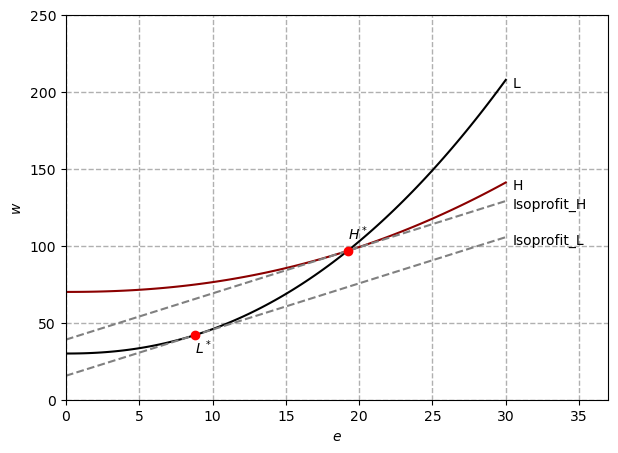

In [8]:
model.solve(do_print=True) #solving the expanded model
model.find_indifference_curves() # calling the function in the "PrincipalAgent"-class that finds the indifference curves
model.find_isoprofit_curves() # doing the same for isoprofit curves
model.plot_everything() # calling the plotting function

From the graph above, we can see that the isoprofit curve and utility curve for the low productivity workers are tangent to each other in the implied solution ($L^\ast$). The same goes for the isoprofit curve and utility curve for the high productivity workers in $H^\ast$. This means that both the $IR_L$ and $IR_H$ bind. 

Furthermore, we can assert that the $IC_L$ binds because the two utility curves cross each other in the solution $H^\ast$. THis means that the low productivity workers attain the same utility from choosing their designated contract and choosing the high productivity contract - which is exactly what the $IC_L$ postulates.

#### <a id='toc2_2_2_'></a>[Varying the parameters](#toc0_)

Now, we test the implications of increasing the cost of taking an education for the high productive workers, $b_H$.

**Procedure**
1. First, we change the cost of education for the high productive workers. 
2. We solve the model. 
2. We find the indifferent curves and the isoprofit curves. 
3. Finally, we plot everything.

(w_L,e_L,w_H,e_H)=(42.026,8.808,129.948, 23.092)
profits=111.863


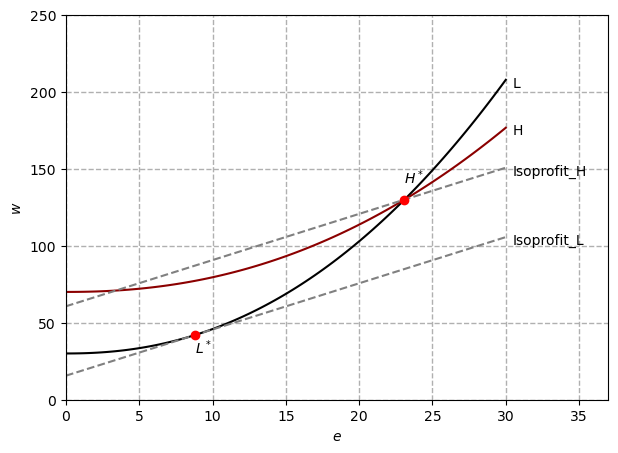

In [9]:
model.par.b_H=1.5 #increasing b_H
model.solve(do_print=True) #solving the expanded model
model.find_indifference_curves() #calling the function that finds the indifference curves in the class
model.find_isoprofit_curves() #doing the same for isoprofit curves
model.plot_everything() #calling the plotting function that combines the indifference curves, isoprofit curves and solutions in a plot

Above, $IR_{H}$ does not bind anymore ($H^\ast$ is no longer in a point where $\text{Isoprofit}_H$ and the utility curve $H$ are tangent to each other). The intuition is that we increase the disutility cost of taking a longer education for high-productive workers, which means that in order to satisfy $IR_{H}$ the firm must increase the wage to high-productive workers at any given level of education. At the same level of education as the previous optimal contract for high-productive worker this wage increase will imply that low-productive workers have incentives to choose the contract intended for high-productive workers. To avoid this the firm increases both the wage and the required education level until the low-productive workers are indifferent between their own contract and the contract intented for the high-productive workers. That is when $IC_{L}$ binds. 

Now we see that an *information cost* has occured due to asymmetric information, because **under full information the firm could have designed a contract increasing its profits without making high-productive workers worse off**. Therefore, the outcome is no longer efficient.



#### <a id='toc2_2_3_'></a>[Boundary/corner solutions](#toc0_)

So far, the inner solutions for the extended model has maximized profits. However, with adequate parameter values (i.e., when the ratio between productivity level and outside option for a worker type is too low) the inner solution might not be the solution that maximizes the firm's profits. It may be the case that it is more profitable for the firm to design a single contract that only one of the worker types is willing to accept or a contract that none of them are willing to accept. Our algorithm accomodate these boundary and corner solutions as it compares the profits from the inner solution with the profits from potential boundary/corner solutions.

For example, below we have increased the outside option of the high productity workers a lot, such that the inner solution for high productivity workers will in all likelihood contribute negatively to the total profits of the firm. Therefore, in this case the actual solution is therefore a boundary solution. In this case, the profit maximizing behavior will therefore be to only design an optimal contract for the low productives, and hence not hire any high productivity workers.


#### <a id='toc2_2_4_'></a>[Varying the outside options](#toc0_)

In [10]:
model = PrincipalAgent() #resetting the model
model.par.r_H = 500 #increasing r_H compared to baseline model
model.solve(do_print=True) #solving the expanded model

(w_L,e_L,w_H,e_H)=(42.035,8.823,0.000, 0.000)
profits=42.218


In the next example below, we now reset the parameter values and instead we increase the outside option of low productivity workers. In this case, the optimal contract becomes a boundary solution again. Now, it is optimal for the firm to design a contract that only high productivity workers are willing to accept. 

In [11]:
model = PrincipalAgent() #resetting the model
model.par.r_L = 200 #increasing r_L
model.solve(do_print=True) #solving the expanded model

(w_L,e_L,w_H,e_H)=(0.000,0.000,95.820, 18.933)
profits=80.489


Now, we consider an example where the differences between high producitivity and low productivity workers are very small regarding their respective outside options and idiosyncratic productivity levels. In that case, it might yield higher profits for the principal to design a single contract that both low productivity and high producitivity workers are willing to accept, because the differences between these workers are so small that the information costs in the inner solution becomes too high. 

An example of this can be seen below where both the outside option and productivity level for L is only 0.1% lower than the values for H. Thus, it is optimal to design a single contract that both high-and low productivity workers are willing to accept.

In [12]:
model = PrincipalAgent() #resetting the model
model.par.r_L = model.par.r_H*0.999 #setting r_L to be very close to r_H
model.par.y_L = model.par.y_H*0.999 #setting y_L to be very close to y_H
model.solve(do_print=True) #solving the expanded model

(w_L,e_L,w_H,e_H)=(81.965,8.824,81.965, 8.824)
profits=144.406


Finally, we consider an example below where both high producitiy and low productivity workers have a relatively high outside option compared to their idiosyncratic producitiy levels. In this case, we see that both the inner solutions and the two boundary solutions considered before implies negative total profits. Thus, it will now be profit maximizing the firm not to offer contracts to any of the worker types, and thereby obtain no profits.

In [13]:
model = PrincipalAgent() #resetting the model to baseline parameters
model.par.r_L = 500 #specifying r_L
model.par.r_H = 200 #specifying r_H
model.solve(do_print=True) #solving the expanded model

(w_L,e_L,w_H,e_H)=(0.000,0.000,0.000, 0.000)
profits=0.000


#### <a id='toc2_2_5_'></a>[Varying the shares of high- and low productivity workers](#toc0_)

Now we'll visualize what different values of q will imply for the model. That is, what different shares of high and low productive workers imply for the wage and education level in optimum.

(w_L,e_L,w_H,e_H)=(42.033,8.823,0.000, 0.000)
profits=84.436
(w_L,e_L,w_H,e_H)=(91.952,18.131,95.816, 18.932)
profits=160.979


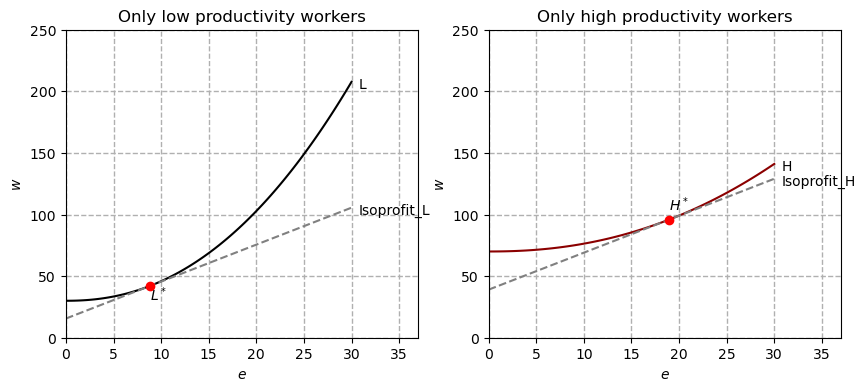

In [14]:
model = PrincipalAgent() # reset parameter values to baseline values
model.two_plots() # calling the plotting function

When only low productivity workers are hired we see the wage and education level is exactly the same for low-productivity workers as it was when $q=\frac{1}{2}$. This is because $IR_L$ binds (and $IC_L$, but $IC_L$ is irrelevant when there are only low-productive workers). 

When we only have high productive workers, the solution changes. This is an interesting result. We find that both the number of years of education demanded and the wage paid fall in equilibrium for the high-productive workers. The reason is that there exists no low-productive workers in this economy, which entails that the principal no longer have to demand a relatively higher education level (and pay relatively higher wages) in order to secure that only high-productive workers accept the high-productive contract. In other words, **the $IC_L$ constraint does not bind anymore**, so the principal can demand a lower education level and pay lower wages because it does no longer have keep the low productive away from the contracts designed for the high productive (there is no information cost). With only one type of agent in the economy (high productive), this is exactly what we would expect. 

Note that when there are only high-productive workers, the principal will not offer a contract to the low-productive workers. We still get a "solution" for the low-productive in order to comply with the constraints, we can however ignore this solution as it is irrelevant.

##### <a id='toc2_2_5_1_'></a>[Interactive plot: Varying the share of high productivity workers](#toc0_)

To show what happens in between the two extremes of $q=0$ and $q=1$, we present an interactive plot where you can vary the share of high productivity workers in the economy.

This is presented below.

In [15]:
model.plot_q(do_print=True) # Interactive plot of optimal wage and education level, given q

interactive(children=(FloatSlider(value=0.5, description='q', max=1.0), Output()), _dom_classes=('widget-inter…

## <a id='toc3_'></a>[Part 3: What if we added more types of workers to the model?](#toc0_)

### <a id='toc3_1_'></a>[The model with n types of agents](#toc0_)

$$
\begin{align*}
\max_{w_1,w_2,\ldots,w_n,e_1,e_2,\ldots,e_n} \pi  & = q_{1}(R_1 - w_1)+q_{2}(R_2 - w_2)+ \cdots +q_{n}(R_n - w_n)\\
& \text{s.t.} \\
\tag{$IR_i$}u_i(w_i,e_i) & \ge r_i  \\ 
\tag{$IC_i$}u_i(w_i,e_i) & \ge u_i(w_j,e_j)\\
\end{align*}
$$

for all $i,j\in \{1,\ldots,n\}$ and $i \neq j$. Moreover, $q_i$ denotes the share of total workers characterized as worker type $i$ 

In [16]:
model = PrincipalAgent() # Creating an instance of the PrincipalAgent class
model.setup_many() # Calling the setup_many function which creates the basic setup for the model with many agents

Consider a population of $N=10,000$ workers. The distribution of workers is normal, such that
$$y_{j}\sim\mathcal{N}(180,100),$$
 where $y_i$ is a discrete set of $n$ linearly spaced values in the interval [10;350]. Therefore, the 10,000 workers can be grouped into $n$ different types of workers, where workers within each type of worker has the same: productivity level, $y_i$, disutility from education, $b_i$ and outside option, $r_i$. 

We assume that disutility from education and worker's productivity level are negatively correlated. That is, the more productive a worker is, the less disutility he/she faces from taking an education. Thus $b_i$ is is a discrete set of $n$ linearly spaced values in decending order in the interval [3.5;1.0]. 

Finally we assume that the outside option is a positive deterministic function of the level of productivity that smaller than the productivity level and increasing in the productivity level, given by the following function:
$$ r_i=y_i*0.4$$

In the interactive figure below, we have illustrated the distribution of the $N=10,000$ workers. The integer slider allows us to see the distribution at various numbers of types of workers, $n$.

In [17]:
model.plot_distribution() # calling the function from the PrincipalAgent class that plots the distribution workers with different productivity levels

interactive(children=(IntSlider(value=10, description='Types of workers', min=1), Output()), _dom_classes=('wi…

The figure above clearly shows the different types of workers are drawn from a normal distribution, and that the distribution is centered around 180. Furthermore, we see that the types of workers are dispersed with equally spaced intervals as intended. 

When the number of types of workers is increased, the distribution of workers becomes more and more dense. This is because the intervals between the different types of workers become smaller and smaller as the productivity varies for every type of worker.

### <a id='toc3_2_'></a>[Solving the model](#toc0_)

**Solution algorithm**
1. Setup baseline parameters in `self.__init__()` in the class `PrincipalAgent()`, and setup arrays of predetermined values (dependending on baseline parameters) in `self.setup_many()`. In `self.setup_many()` we use `numpy.linspace` to draw linear spaced values of $y_i$ and $b_i$, and moreover we use `scipy.stats.norm` to make the distribution of workers in the population normally distributed, and then we extract the probabilities for each of the discrete set of productivity levels according to this. 

2. Formulate the utility and profit functions in respectively `self.u(b,w,e)` and `self.profits_many(*args)`. The profit function takes `*args` as an argument, which allows us to use a variable number of arguments depending on the number of worker types, $n$. `args` is a tuple of $2*n$ arguments to maximize with relation to, where the first $n$ elements are the wages and the next $n$ elements are the education levels. We specify the profit function by only adding the profit provided by a worker type if the worker's IR-constraint holds (i.e. if the worker accepts the contract).

3. Next, we formulate the objective function and constraint functions (`self.objective_many(x)` and `self.constraints_many(x)`). The `self.objective_many(x)` takes the list `x` as an argument and unpacks this in the negative of the profit function. The `self.constraints_many(x)`-method appends a IR-constraint and $n-1$ IC-constraints for each of the $n$ worker types to a list of constraints and returns this list of $n*n¤ elements.

4. Finally, in the `self.solve_many()`-method we call an optimizer and solve the model of interest. As for the previous models we all the optimizer `scipy.optimize.minimize` and use the method SLSQP as we have a constrained optimization problem. The bounds specified in the optimizer is that wages must be non-negative and that the education level must be non-negative and can maximum take a value of 30 years.

Due to the potentially many constraints in the problem with $n$ agents, we only focus on the inner solution as the algorithm quickly becomes very complex if we want to compare profits with alternative contracts not satisfying all the constraints. This implementation would be a good starting point if we seeked to take the analysis of the model with $n$ agents to a next level, meanwhile the objective of this part is just to show that it is possible to make further extensions to the model, e.g. by including a variable number of agents. 

##### Solving the model with baseline parameter values

In [18]:
model.solve_many(do_print=True) # calling the function to solve the model for many agents

Worker type 1:   (y,w,e) = (10.00, 71.70, 5.49)
Worker type 2:   (y,w,e) = (47.78, 72.78, 5.92)
Worker type 3:   (y,w,e) = (85.56, 75.52, 6.95)
Worker type 4:   (y,w,e) = (123.33, 87.03, 10.30)
Worker type 5:   (y,w,e) = (161.11, 114.99, 15.76)
Worker type 6:   (y,w,e) = (198.89, 155.95, 21.57)
Worker type 7:   (y,w,e) = (236.67, 169.31, 23.29)
Worker type 8:   (y,w,e) = (274.44, 194.45, 26.57)
Worker type 9:   (y,w,e) = (312.22, 194.48, 26.58)
Worker type 10:  (y,w,e) = (350.00, 194.81, 26.65)

profits = 98.77


We see that for 10 types of workers, there exists 10 different types of contracts offered from the principal to the agents. 

The results are essentially the same as when we only had two types of workers. That is, the least productive workers are offered the lowest wage and demanded to have the lowest number of years of education. Furthermore, the most productive workers are offered the highest wage and demanded to have the highest number of years of education.

Once again, we can mention that there is an equal distance between the productivity of each type of worker. However, we note that this is not the case for the distance between the demanded number of years of education for each type of worker. This is because the disutility from education is increasing in the number of years of education. Therefore, the principal will demand a higher number of years of education for the types of workers with a higher productivity level. Because of the demands for higher education, the principal also has to offer a higher wage to the more productive.

We increase the number of type of workers to $n=20$ and solve the model again:

In [19]:
model.ext.n = 20 # changing the number of agents to 20
model.solve_many(do_print=True) # solving the model for 20 agents and printing the results

Worker type 1:   (y,w,e) = (10.00, 74.07, 5.41)
Worker type 2:   (y,w,e) = (27.89, 74.37, 5.54)
Worker type 3:   (y,w,e) = (45.79, 74.99, 5.80)
Worker type 4:   (y,w,e) = (63.68, 77.67, 6.84)
Worker type 5:   (y,w,e) = (81.58, 77.95, 6.94)
Worker type 6:   (y,w,e) = (99.47, 82.56, 8.46)
Worker type 7:   (y,w,e) = (117.37, 87.94, 9.96)
Worker type 8:   (y,w,e) = (135.26, 98.83, 12.47)
Worker type 9:   (y,w,e) = (153.16, 113.14, 15.16)
Worker type 10:  (y,w,e) = (171.05, 131.42, 18.07)
Worker type 11:  (y,w,e) = (188.95, 154.08, 21.19)
Worker type 12:  (y,w,e) = (206.84, 159.77, 21.94)
Worker type 13:  (y,w,e) = (224.74, 159.80, 21.94)
Worker type 14:  (y,w,e) = (242.63, 176.72, 24.25)
Worker type 15:  (y,w,e) = (260.53, 194.42, 26.57)
Worker type 16:  (y,w,e) = (278.42, 194.43, 26.57)
Worker type 17:  (y,w,e) = (296.32, 194.43, 26.57)
Worker type 18:  (y,w,e) = (314.21, 194.46, 26.58)
Worker type 19:  (y,w,e) = (332.11, 194.50, 26.58)
Worker type 20:  (y,w,e) = (350.00, 194.57, 26.60)



Now, the solution follows the exact same pattern as when we had $n=10$, only this time we have 20 contracts offered. This is because the distribution of workers is still normal, and the distribution is still dispersed with equally spaced intervals centered around 180. 

### <a id='toc3_3_'></a>[Plotting the solution](#toc0_)

We can plot the solutions for the optimal number of years of education and the optimal wage for each type of worker against the productivity level. In other words, we can plot the optimal contracts given the type of worker.

This is done with the function `py.plot_many` in the `modelproject.py`-file under the `PrincipalAgent`-class. 

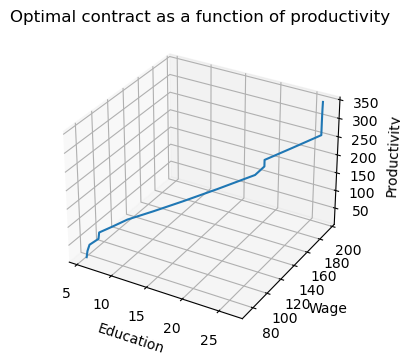

In [20]:
model.plot_many() # calling the function that plots the series of optimal contracts

The plot above clearly illustrates the points from before; the wage offered and education demanded is increasing in the productivity level. 

## <a id='toc4_'></a>[Conclusion](#toc0_)

In this assignment we have solved the Principal-Agent model numerically.

### <a id='toc4_1_'></a>[Part 1](#toc0_)
In the first part we present the Principal-Agent model with adverse selection. Here, we do not allow the principal to condition on the agents' years of education (no screening available). Therefore, the principal can only supply one contract to both types of workers. We find that this solution depends strongly on the parameters chosen, especially the reservation utility (outside option). We find that this version of the model can result in the three different solutions:

**1.** The principal hires the both types of workers and incur *positive* profits and pays a relatively *high* wage

**2.** The principal hires the low productivity workers and incur *positive* profits and pays a relatively *low* wage

**3.** The principal chooses *not to hire* the two agents and incurs zero profits

### <a id='toc4_2_'></a>[Part 2](#toc0_)
**Screening**

In part 2, we expand the model. Now, we allow for the principal to condition on the agents' years of education (screening available) as a signal for the productivity of the worker. This allows for the principal to offer the two agents different contracts, where the required number of years of education and the wage varies. 

We find that this version of the model implies that the high-productive workers are demanded to have a significantly longer education and in exchange receive a significantly higher wage than low-productive workers. We know that this equilibrium implies that the $IR_L$ and $IC_L$ constraints bind.

**Boundary solutions**

In this part of the project, we asses the boundary solutions of the PA-model. 

We find that the boundary solutions are relevant when the outside option of the workers is high relative to their productivity level. In this case, the principal might find it optimal to only offer a contract to only one of the worker types or not offer any contract at all to avoid a negative impact from hiring on the profits.

**Varying q**

Now, we analyze the implications of different values of q in the model. That is, we analyze the implication of changing the share of high-productive workers in the economy. 

We find that for $q=0$ (only low-productive workers), the contract offered to the low-productive is unchanged from the equilibrium in part 2. This is beacuase the $IR_L$ constraint still binds.

However, for $q=1$ we find that the high-productive workers are demanded to have a shorter education and thus receive a lower wage, when there only exists the productive type of agents in the economy. This is because the $IC_L$ does not bind anymore. In short, we no longer have to keep the low-productive workers away from the contract designed for the high-productive workers, because there are no low-productive workers in the economy (there is no information cost).

### <a id='toc4_3_'></a>[Part 3](#toc0_)
In part 3, we expand the model to allow for n different types of workers. We find that the model can be solved numerically for any number of types of workers, however the computational time increases significantly with the number of types of workers. The reason is that the number of constraints increase quadratically in the types of workers.

The predictions of the model are essentially the same as in part 2 with the expanded model. That is, the least productive workers are offered the lowest wage and demanded to have the lowest number of years of education and then the wage and demanded years of education increase in the productivity of the worker type.